# Titanic: Machine Learning From Disaster
### by Sung Ahn and Abdul Saleh

<hr>
## Introduction
In this project, we use random forests and (gradient boosting) machine learning algorithms to predict who survived the sinking of the RMS Titanic. On our journey to achieving this goal, we go through the whole data science process from understanding the problem and getting the data to fine-tuning our models and visualizing our results. 

The Titanic dataset is perhaps the most widely analyzed dataset of all time. There exists a wealth of incredible tutorials online exploring different approaches to analyzing this dataset. So in our own analysis, we draw on the experiences of the huge community of amazing people who have already attempted this problem and shared their conclusions online. We would especially like to thank [Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions), [Jeff Delaney](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish), and [Ahmed Besbes](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html) whom without their insight this project would not have become a reality.    

<hr>
## Outline 
1. Understanding the problem
2. Getting the data
3. Exploring the data 
4. Picking a machine learning algorithm 
5. Preparing the data for machine learning algorithms
6. Training algorithm and fine-tuning model
7. Visualizing results and presenting solution 


<hr>
## Understanding the problem
Before we dive into the data analysis and algorithms, we first ask ourselves: is this even a problem that can be solved with machine learning? <br>
Luckily for us, lots of books have been written about the sinking of the Titanic. So before we look at the data, we do some background reading and discover that some patterns might exist, most notably: 

1. Women and children generally got first priority on the life boats 
    - This tells us that we should look for 
2. The third class living quarters were the furthest away from the deck with the lifeboats
    - This tells us that it was likely they got there later than sooner
    - Considering that the time of impact was at 11:40 PM, most of the passengers were probably in their cabins at the time of impact
3. There was a lot of confusion during the sinking of the ship and people chose to stay on the Titanic for arbitrary reasons. 
    - There are definitely anomalies in this dataset because it is clear that not all people had the same opportunity to get on the lifeboats
4. The Titanic first left from Southampton, then picked up passengers at Cherbourgh, then finally at Queenstown
    - Perhaps we could look for some patterns with class and fare?
5. The timeline of the Titanic is as follows:
    - 2340: Impact at the starboard side
    - 0005: Orders given to uncover the lifeboats and get everyone ready
    - 0025: Lifeboat begin being loaded with women and children
    - 0045: First lifeboat lowered with less than half of its max capacity
    - 0205: The last lifeboat leaves the ship with over 1500 people left <br>
    
    - So it definitely took a while for the Titanic to sink and people to get on board the lifeboats
    - The captain did not get on the lifeboats

Aha, so it seems like a there are some patterns that can help us figure out who survived and who didn't. This looks like a great machine learning problem!

<hr>
## Getting the data
Kaggle, a platform for data science competitions, has kindly compiled a dataset that is perfect for our needs and put it on their [website](https://www.kaggle.com/c/titanic/data) for budding machine learning enthusiasts to use. The training dataset tells us who survived and who didn't so we can use it to train our model. The test set doesn't tell us the fate of the passengers - that's what we're supposed to predict!

After downloading the datasets, we import the data and a few libraries that we will use later on.  

In [218]:
# for data analysis
import pandas as pd
import numpy as np

# for visualizations
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# for machine learning
from sklearn.ensemble import RandomForestClassifier

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# import data 
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

<hr>
## Exploring the data

Now let's take a look at the data:

In [219]:
display(train_data)
print('_'*125)
display(test_data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


_____________________________________________________________________________________________________________________________


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


#### What do **Pclass**, **SibSp**, and **Parch** mean? <br>
According to Kaggle, **Pclass** = passenger class, **Sibsp** = # of siblings/spouses aboard the Titanic, **Parch** = # of parents/children aboard the Titanic. 
<br>

#### What are the important feature types? 
- Categorical features: **Survived, Sex, Embarked, Pclass**
- Numerical features:
  - Discrete: **SibSp, Parch**
  - Continuous : **Fare, Age**
- Alphanumeric features: **Cabin, Ticket**


In [220]:
# to find out size of data
print("training data dimensions:", train_data.shape)

training data dimensions: (891, 12)


In [221]:
# What are the data types? Are there missing values?
train_data.info()
print('_'*125)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
_____________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp     

#### What are the missing values? 
- From training set:
    - 687 missing **Cabin** values
    - 177 missing **Age** values
    - 2 missing **Embarked** values
- From test set:
    - 327 missing **Cabin** values
    - 86 missing **Age** values

In [222]:
# Summarize integer and float type features
train_data.describe()
# Show more details about specific features
#data_train.describe(percentiles=[], include=["Pclass"])
#data_train.describe(percentiles=[], include=["Pclass"])
#data_train.describe(percentiles=[], include=["Pclass"])
#data_train.describe(percentiles=[], include=["Pclass"])
#data_train.describe(percentiles=[], include=["Pclass"])"""

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### What do numerical features tell us?
- The sample's survival rate is ~38% which is a bit higher than the actual 32%
- Most passengers on board were in 3rd class, while less that 25% where in 1st class
- More than 75% of passengers were less that 38 years old and the mean age was 30 
- More than 75% of passengers did not travel with their kids or their parents


In [223]:
# Summarize object type features
train_data.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Minahan, Miss. Daisy E",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


### What this tells us

Hmm, it looks like we have some missing embarked values, as well as ages and lots of missing cabin numbers. We will have to figure out ways to deal with those later on. 

<hr>
## Preparing the data for machine learning algorithms
First we start by combining the training dataset and the test dataset so that we can edit them both together and ensure they end up in the same format. 


In [224]:
backup_copy = train_data
# Store the survival data
targets = train_data.Survived

# Drop survival data so training set and test set have the same shape and can be combined
train_data_dropped = train_data.drop(["Survived"], 1)

# Combine train and test data
combined_data = train_data_dropped.append(test_data)

combined_data.shape

(1309, 11)

The training data had 891 entries and the test data had 418 entries. $418 + 891 = 1309$ entires, so this looks good!

### Extracting passenger titles: 

In [225]:
combined_data.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
431,432,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
480,481,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
645,646,1,"Harper, Mr. Henry Sleeper",male,48.0,1,0,PC 17572,76.7292,D33,C
202,1094,1,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C
151,152,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
412,413,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0000,C78,Q
802,803,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
211,212,2,"Cameron, Miss. Clear Annie",female,35.0,0,0,F.C.C. 13528,21.0000,NaN,S
782,783,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
199,1091,3,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,NaN,0,0,65305,8.1125,NaN,S


Note in the above sample that passenger titles are always preceded by a comma and followed by a period. So we can create a function that splits the Name value at the comma and at the period to get the title.

In [226]:
# Extract titles from names and place them in a new column
combined_data["Title"] = combined_data["Name"].map(lambda name: name.split(",")[1].split(".")[0].strip())

# Drop names column because we no longer need it
combined_data.drop(["Name"], 1, inplace=True)

# Show all different values in the Title column
combined_data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Capt              1
the Countess      1
Sir               1
Jonkheer          1
Lady              1
Don               1
Mme               1
Dona              1
Name: Title, dtype: int64

Looks like it worked!
<br>
Here we don't need to worry about "binning" similar titles together because tree based models like the random forest classifier can decide for themselves which binning is most useful for predicting outcomes. 

### Processing passenger ages:

If you recall from the data exploration step, there were about 177 and 86 missing age values from the training set and the data set respectively. We know that age is an important factor in determining survival so we need to come up with a way to fill in the missing ages.

Here we are going to group people by their gender, class, and title and then use these groupings to determine the missing values. This approach was used by Ahmed Besbes [here]("https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html").

# Select train data and group by Sex, class, and title in that order
grouped_train_data = combined_data.head(891).groupby(["Sex","Pclass", "Title"])

# Select test data and group by Sex, class, and title in that order
grouped_test_data = combined_data.iloc[891:].groupby(["Sex", "Pclass", "Title"])

# Find and display medians 
display(grouped_train_data.median())
print('_'*125)
display(grouped_test_data.median())

So the function we want to create to fill in the missing ages first checks the passenger's age, then their class, then their title and uses that info to determine what age to give them. If we haven't seen that title before, we should just plug in the median age.

 <div class="alert alert-block alert-warning">Note that we have to be super careful not to introduce any information from the training data into the test data. The point of a predictive machine learning model is to make accurate predictions about new data that is *unseen* during the training.</div>

# Some Histograms

Histograms are particularly useful in visualizing data and figuring out what to do with the data. <br>

**NOTE**: *All of the codes used for the histograms were extracted from the website https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html and modified for our purposes.*

## Comparing various things with 'Survival'
These are the parameters that are available to us:

- Survived
- Pclass
- Sex	
- Age	
- SibSp	
- Parch
- Ticket
- Fare
- Cabin
- Embarked

We will not show the histogram for the ticket and the cabin, since there weren't any noticeable patterns. <br>
Of these, the things that we really want to look out for are any correlations with sex, age, and pclass. The rest we put in case there may be a possible correlation.

##### Passenger Class
Note that an even amount of people survived in terms of classes, but proportionately, a bit more of the first class survived, about the same amount of the second class survived, and much more of the third class did not survive.

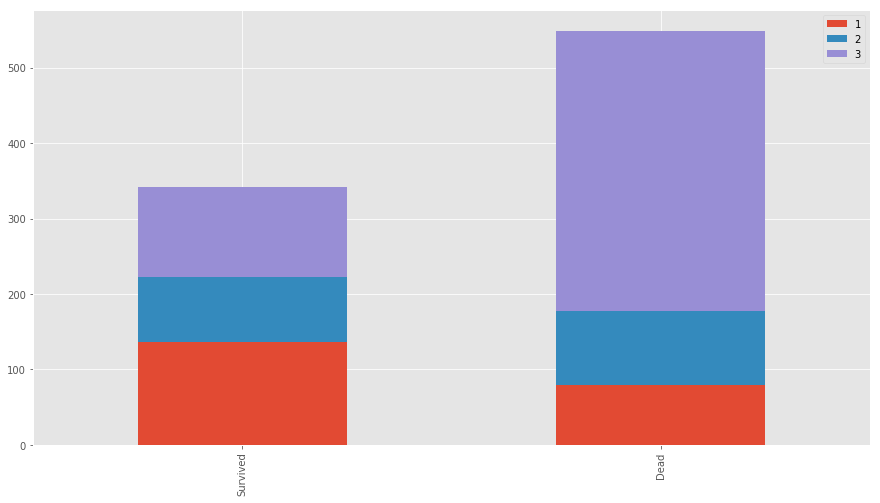

In [227]:
survived_class = train_data[train_data['Survived']==1]['Pclass'].value_counts()
dead_class = train_data[train_data['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_class,dead_class])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

##### Sex
Note that, proportionally, more females survived, as expected from what we know during the crash.

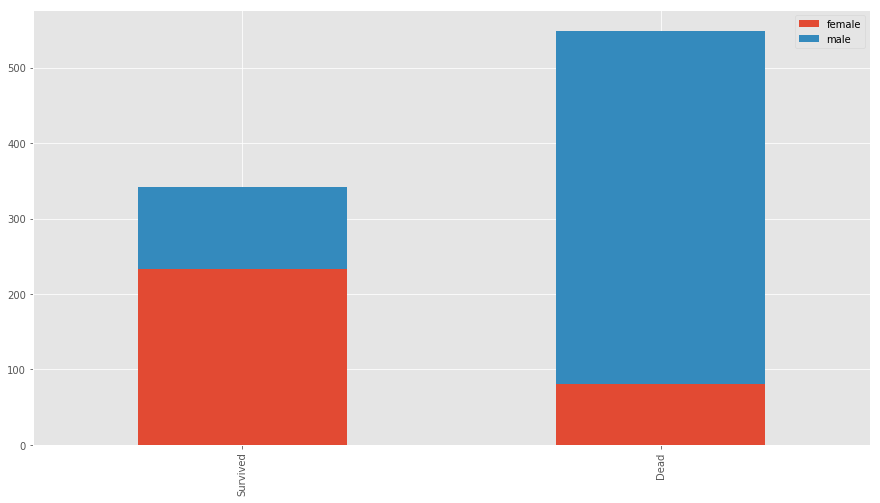

In [228]:
survived_sex = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead_sex = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

##### Age

Note that the younger and the older "age bracket" is the one that more people survived in.

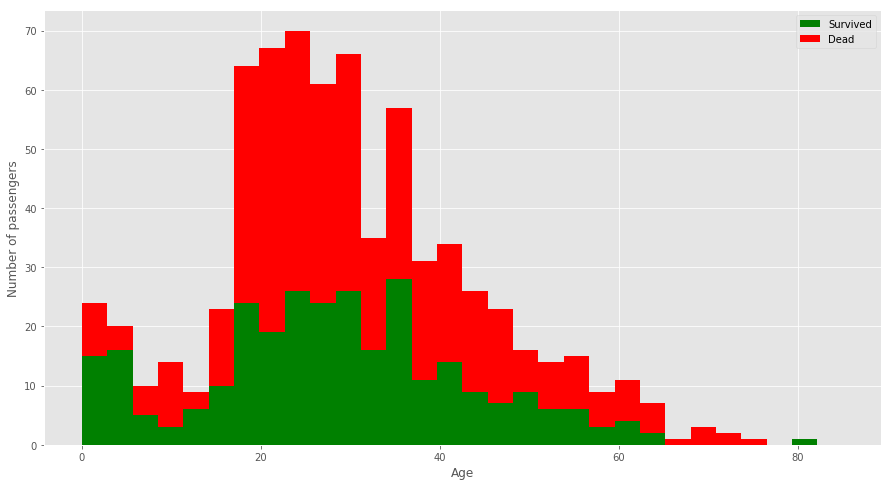

In [229]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Age'], train_data[train_data['Survived']==0]['Age']], 
         bins = 30, range = (0,85), align='mid', color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

##### Siblings and Spouses
The result of this is mixed; it definitely seems that the people with more siblings and/or spouse did not survive; however, most people with no siblings or spouses did not survive as well.

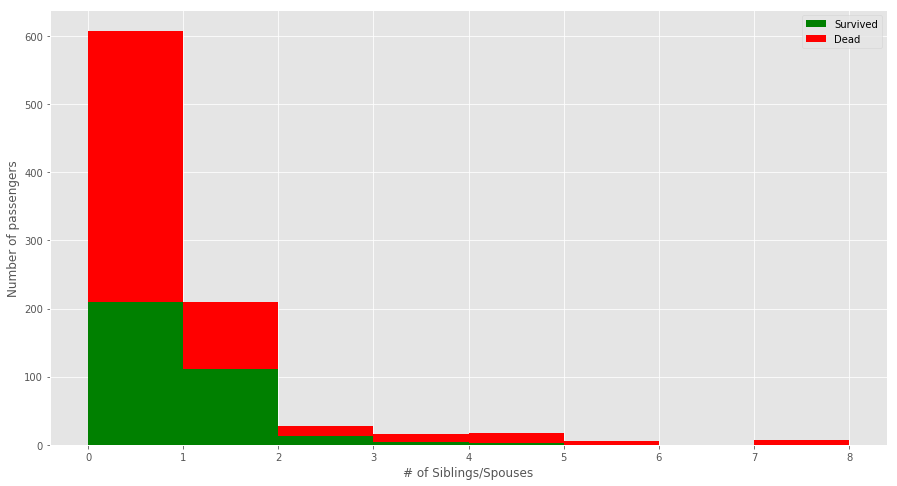

In [230]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['SibSp'], train_data[train_data['Survived']==0]['SibSp']], 
         bins = 8, range = (0,8), color = ['g','r'], align='mid', label = ['Survived','Dead'], stacked=True)
plt.xlabel('# of Siblings/Spouses')
plt.ylabel('Number of passengers')
plt.legend()

##### Parents and Children
There doesn't seem to be anything that is too interesting. Here is the histogram for all numbers:

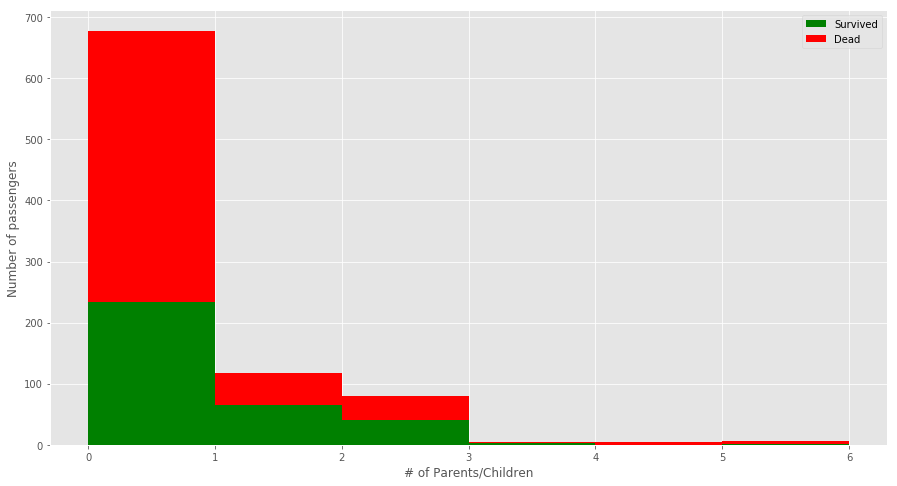

In [231]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Parch'], train_data[train_data['Survived']==0]['Parch']], 
         bins = 6, range = (0,6), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('# of Parents/Children')
plt.ylabel('Number of passengers')
plt.legend()

And the histogram for numbers above 1:

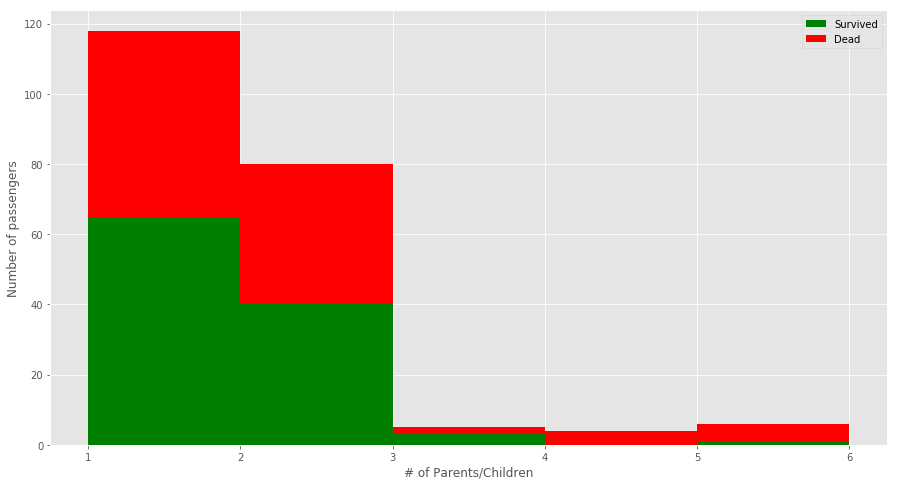

In [232]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Parch'], train_data[train_data['Survived']==0]['Parch']], 
         bins = 5, range = (1,6), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('# of Parents/Children')
plt.ylabel('Number of passengers')
plt.legend()

##### Fare
There doesn't seem to be such a large difference in terms of general patterns here; as expected, really. There doesn't seem to be any sort of real correlation between how much someone paid for their ticket and how likely it was that they survived. Below is a histogram for all of the fares:

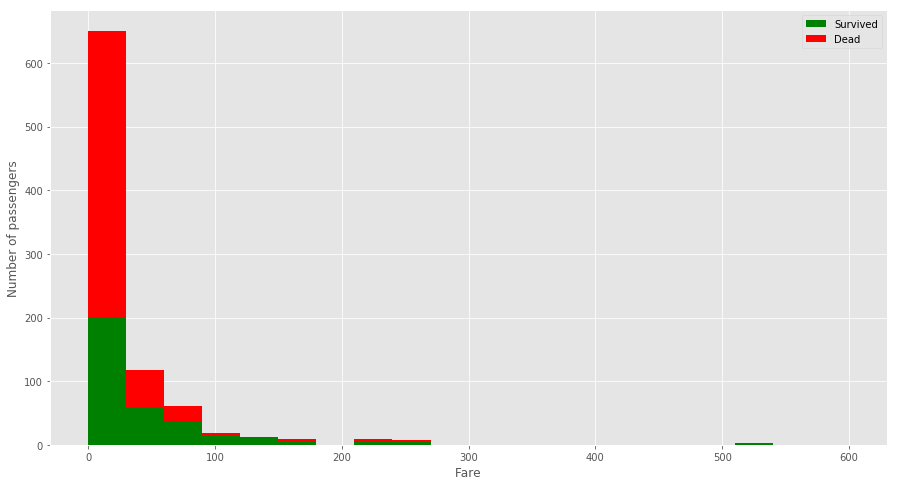

In [233]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Fare'], train_data[train_data['Survived']==0]['Fare']], 
         bins = 20, range = (0,600), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

And below is a historgram for the more expensive fares, above 30 dollars:

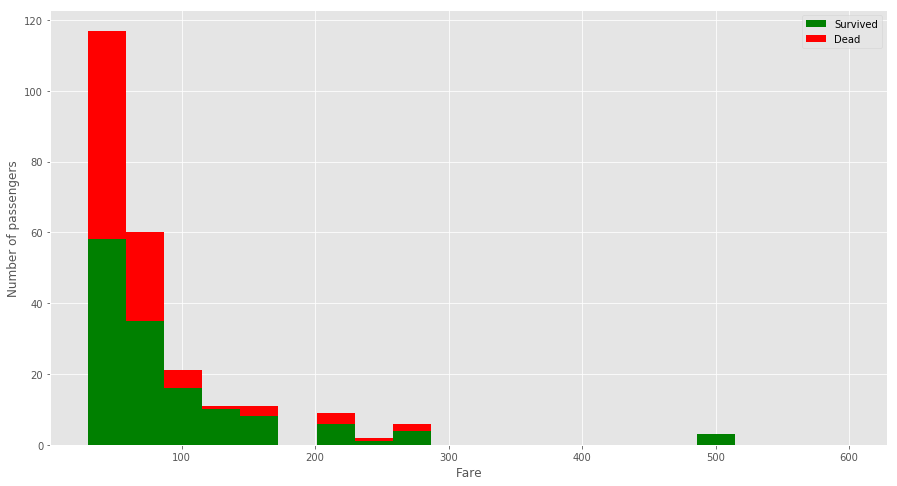

In [234]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Survived']==1]['Fare'], train_data[train_data['Survived']==0]['Fare']], 
         bins = 20, range = (30,600), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

##### Embarked
Note that the most people on the ship embarked from Southampton, where the Titanic originally embarked from.

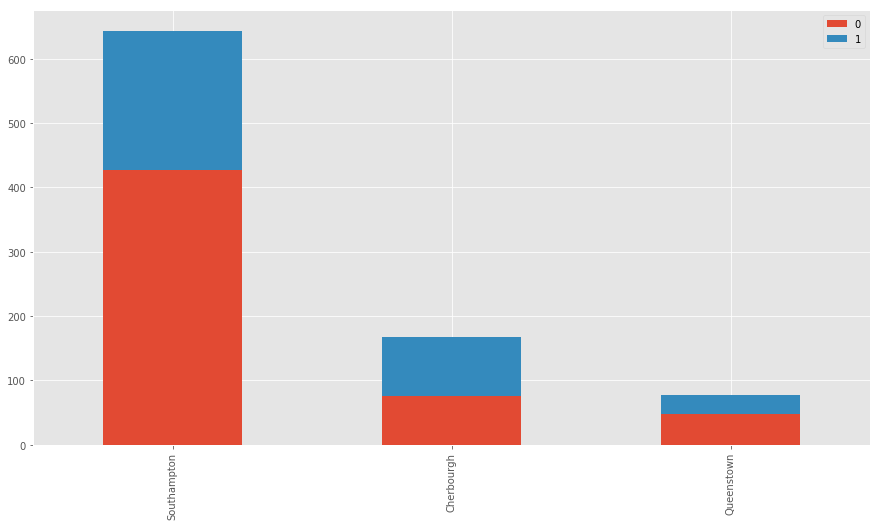

In [235]:
S = train_data[train_data['Embarked']=='S']['Survived'].value_counts()
C = train_data[train_data['Embarked']=='C']['Survived'].value_counts()
Q = train_data[train_data['Embarked']=='Q']['Survived'].value_counts()
df = pd.DataFrame([S,C,Q])
df.index = ['Southampton','Cherbourgh','Queenstown']
df.plot(kind='bar',stacked=True, figsize=(15,8))

## Comparing two variables

##### Class vs. Fare

Below we have a plots that looks at the relationship between the *ticket class* and the *fare*. It definitely looks like there is some sort of relationship, and as any dmand curve suggests, more people bought lower-priced tickets. The curve is not particularly surprising.

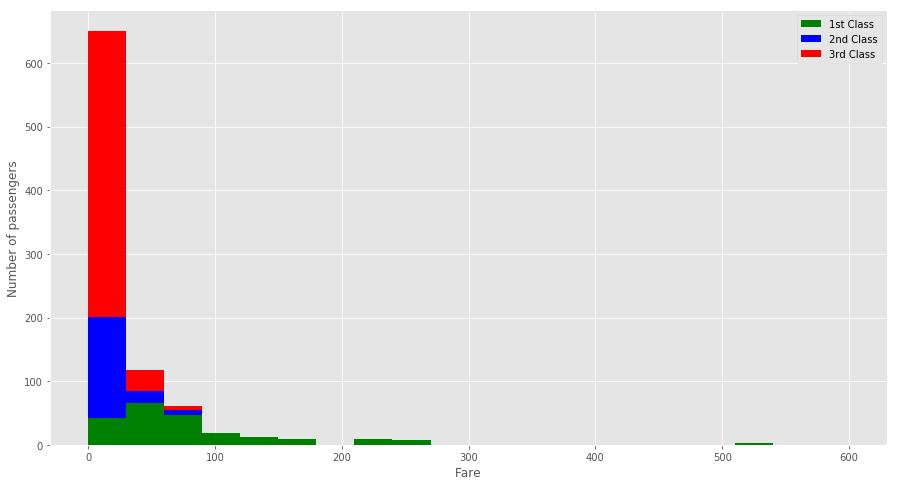

In [236]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Pclass']==1]['Fare'], train_data[train_data['Pclass']==2]['Fare'],train_data[train_data['Pclass']==3]['Fare']], 
         bins = 20, range = (0,600), color = ['g','b','r'], label = ['1st Class','2nd Class','3rd Class'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

But let us zoom in at the more expensive tickets:

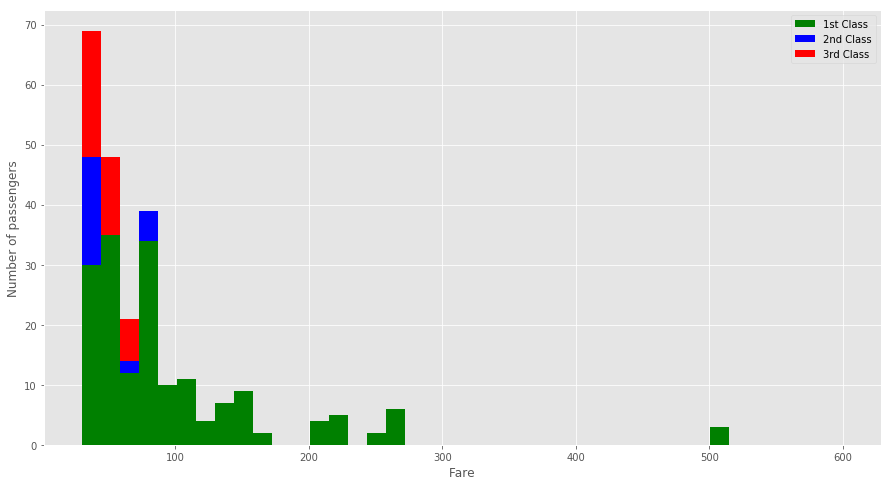

In [237]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Pclass']==1]['Fare'], train_data[train_data['Pclass']==2]['Fare'],train_data[train_data['Pclass']==3]['Fare']], 
         bins = 40, range = (30,600), color = ['g','b','r'], label = ['1st Class','2nd Class','3rd Class'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

There's something strange going on in the second bin; there are no 2nd class purchases. This is a strange anomaly, but we're not really interested in that. What's better shown in these histograms, however, is that the relationship between the fare and the ticket class is not as clear as we may expect them to be. The range and distribution of the classes throughout the fares are there; but there doesn't seem to be any solid correlation to go off of here.

##### Embarked vs. Fare

Below is a graph of the point of embarkment and fare to see if there are any connections. There doesn't seem to be any.

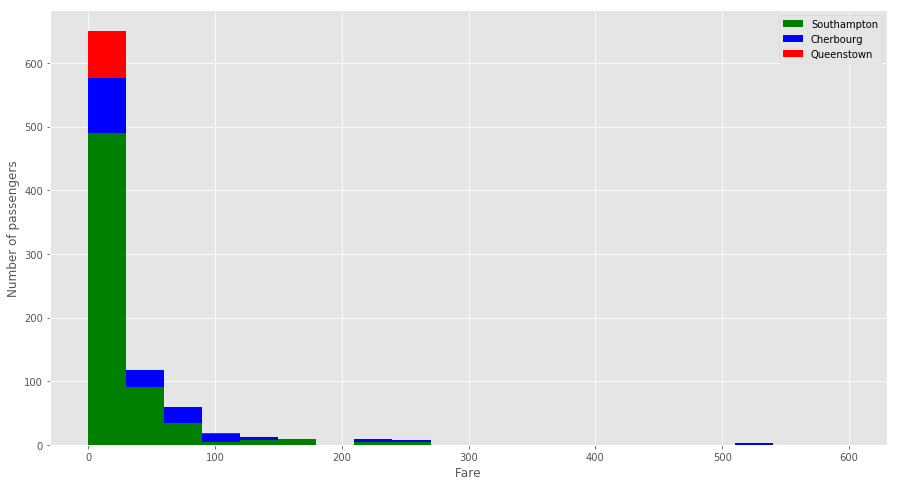

In [238]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Embarked']=='S']['Fare'], train_data[train_data['Embarked']=='C']['Fare'],train_data[train_data['Embarked']=='Q']['Fare']], 
         bins = 20, range = (0,600), color = ['g','b','r'], label = ['Southampton','Cherbourg','Queenstown'], stacked=True)
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

##### Class vs. Age

Below we see if there are any meaningful connections between class and age. There doesn't really seem like it; therefore, we move on.

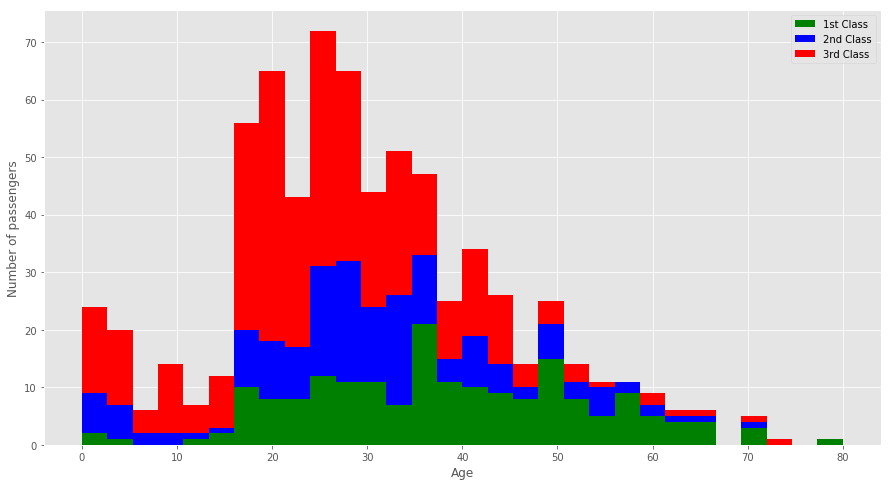

In [239]:
figure = plt.figure(figsize=(15,8))
plt.hist([train_data[train_data['Pclass']==1]['Age'], train_data[train_data['Pclass']==2]['Age'],train_data[train_data['Pclass']==3]['Age']], 
         bins = 30, range = (0,80), color = ['g','b','r'], label = ['1st Class','2nd Class','3rd Class'], stacked=True)
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

##### Class vs. Age vs. Fare

Now we start getting into the meat of the connections. Here, we compare between the class, age, and fare using a scatter plot:

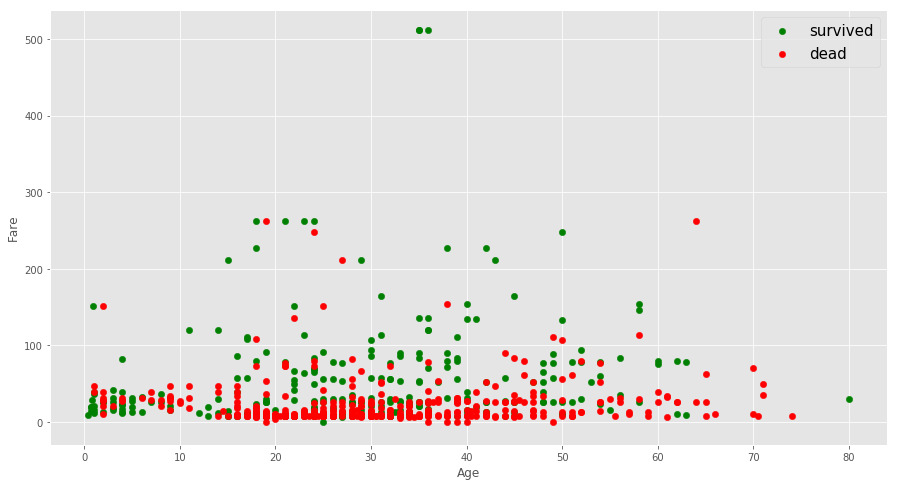

In [240]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(train_data[train_data['Survived']==1]['Age'],train_data[train_data['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(train_data[train_data['Survived']==0]['Age'],train_data[train_data['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

As we can see, there is a distinct cluster of "dead" datapoints at lower fares and between the ages of around 14 to around 52. Now, from the ***Class vs. Age*** plot, most of the the class that dominates this range is, indeed, the 3rd class. This seems to make sense.

### Looking at Family Sizes

We are going to combine some variables, *SibSp* and *Parch*, and hopefully this will give us some more useful data.

In [241]:
# reading train data
train = pd.read_csv('train.csv')

def process_family():
    
    global train
    # introducing a new feature : the size of families (including the passenger)
    train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
    
process_family()

So this should give us the size of the family separately. USing this, we can compare survival rate pretty easily:

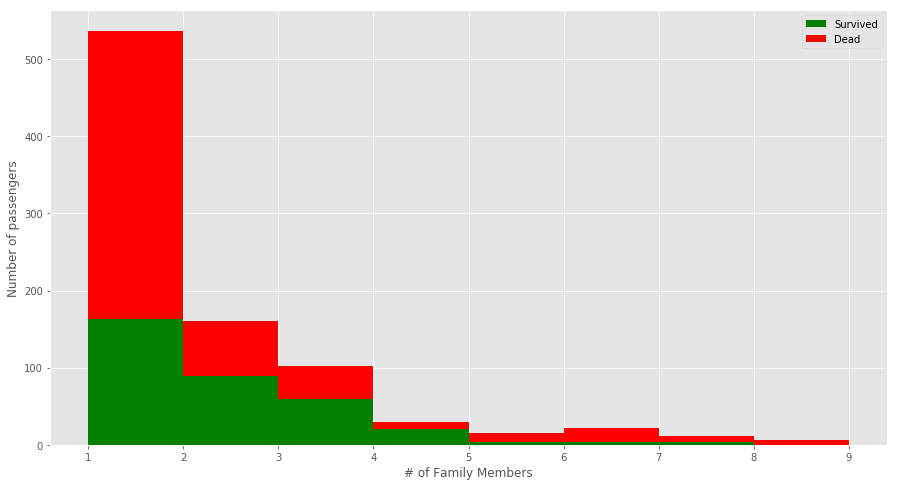

In [242]:
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Survived']==1]['FamilySize'], train[train['Survived']==0]['FamilySize']], 
         bins = 8, range = (1,9), color = ['g','r'], label = ['Survived','Dead'], stacked=True)
plt.xlabel('# of Family Members')
plt.ylabel('Number of passengers')
plt.legend()

So a lot of people who were alone did not survive; this is strange. So let's cross-reference this with *class* and *Family Size*. This one is for those who did not make it:

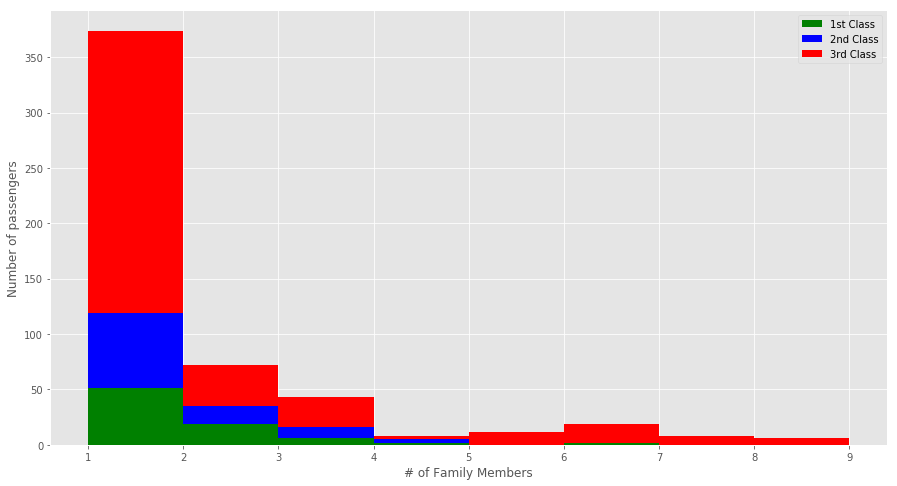

In [243]:
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Pclass']==1][train['Survived']==0]['FamilySize'], 
          train[train['Pclass']==2][train['Survived']==0]['FamilySize'], 
          train[train['Pclass']==3][train['Survived']==0]['FamilySize']], 
         bins = 8, range = (1,9), color = ['g','b','r'], label = ['1st Class','2nd Class','3rd Class'], stacked=True)
plt.xlabel('# of Family Members')
plt.ylabel('Number of passengers')
plt.legend()

So this settles it; most of the people who died alone on the Titanic were alone were in the 3rd class. This makes sense since the people of 3rd class would find it more difficult to buy more tickets, and they were probably not going on family trips at the time. 